# A Study of four financial time series. 

# Introduction : 

We are given four assets : A,B,C and D and will show that we can predict the opening/closing prices of these assets using ARIMA and VAR models. We fit models at first for just the data coming from each asset, we will then run the combined data through the models after employing a dimensionality reduction to obtain slightly better scores. In all cases, our models are tested using a rolling forecast test, which is a form of Cross Validation for time series data. 

# Exploratory Data Analysis  

In [404]:
#Importing necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import scatter_matrix
import seaborn as sns
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import coint
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.decomposition import PCA

In [405]:
# We load the given data onto 4 pandas dataframes.

pathA = '/Users/Welliareetil/Documents/Cabestan-technical challenge/WelliaveetilDataset/A.csv'
pathB = '/Users/Welliareetil/Documents/Cabestan-technical challenge/WelliaveetilDataset/B.csv'
pathC = '/Users/Welliareetil/Documents/Cabestan-technical challenge/WelliaveetilDataset/C.csv'
pathD = '/Users/Welliareetil/Documents/Cabestan-technical challenge/WelliaveetilDataset/D.csv'

In [406]:
A = pd.read_csv(pathA)
B = pd.read_csv(pathB)
C = pd.read_csv(pathC)
D = pd.read_csv(pathD)

In [407]:
#We rename the columns which will come in handy later when studying multiple assets simultaneously.

A.columns = ["date",'op_A', 'hi_A', 'lo_A', 'se_A', 'volume_A', 'oi_A']
B.columns = ["date",'op_B', 'hi_B', 'lo_B', 'se_B', 'volume_B', 'oi_B']
C.columns = ["date",'op_C', 'hi_C', 'lo_C', 'se_C', 'volume_C', 'oi_C']
D.columns = ["date",'op_D', 'hi_D', 'lo_D', 'se_D', 'volume_D', 'oi_D']

In [408]:
# We convert the date columns to timestamps.

A["date"] = pd.to_datetime(A["date"])
B["date"] = pd.to_datetime(B["date"])
C["date"] = pd.to_datetime(C["date"])
D["date"] = pd.to_datetime(D["date"])

In [409]:
#We make note of the start and end dates of the 4 time series. This will be useful when making plot comparisons. 

a_start = A['date'][0]
a_end = A['date'][len(A['date'])-1]
b_start = B['date'][0]
b_end = B['date'][len(B["date"])-1]
c_start = C['date'][0]
c_end = C['date'][6823]
d_start = D['date'][0]
d_end = D['date'][10025]

In [410]:
#We set the index of the 4 dataframes to be the date column. 

A.index = A["date"]
#del(A['date'])
B.index = B["date"]
#del(B['date'])
C.index = C['date']
#del(C['date'])
D.index = D['date']
#del(D['date'])


We will add a column for each time series which is the closing price of the asset for that day. 
We feel that for a particular asset, the features 'op', 'hi',
'lo', 'se', 'volume', 'oi' and 'cl', are known to us only at the close of business each day and hence it makes more
sense to check if this information (and all past values of the features) can then be employed to predict the closing price for the next day. 


In [411]:
#We add a column "closing price" to a given dataframe. We feel this is a more natural variable to predict.

def closing_price_column(df,op,s):
    l = pd.Series([df[op][j+1] for j in range(len(df)-1)] + [0])
    df = df.assign(cl = l.values)
    df = df.drop(df.index[-1])
    df.rename(columns = {'cl':s},inplace = True)
    df.drop(op, axis = 1,inplace = True)
    return(df)

In [412]:
A = closing_price_column(A,"op_A","cl_A")
B = closing_price_column(B,"op_B","cl_B")
C = closing_price_column(C,"op_C","cl_C")
D = closing_price_column(D,"op_D","cl_D")

In [413]:
#Rearrange the columns of the dataframe.

def rearrange(df,s):
    cols = list(df.columns)
    k = cols.index(s)
    t = cols[1]
    cols[k] = t
    cols[1] = s
    df = df[cols]
    return(df)

In [417]:
A = rearrange(A,'cl_A')
B = rearrange(B,'cl_B')
C = rearrange(C,'cl_C')
D = rearrange(D,'cl_D')

# Missing Values and dates

Checking for missing values and any unusual behaviour. We will go into a closer examination when building models 
below.

In [419]:
#A list of lists which gives the column count of missing values for each of the 4 assets

null_list = []
null_list.append(list(A.isnull().sum()))
null_list.append(list(B.isnull().sum()))
null_list.append(list(C.isnull().sum()))
null_list.append(list(D.isnull().sum()))
null_list

[[0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 6, 6, 0, 8, 11, 6]]

We see that the series D has some missing values. 

We check if the data has certain dates missing. We do so by counting 
the number of days between the start and end dates of 
the different series and then multiplying this by (251/365) since 251 is a rough estimate of the number of
working days per year. We then subtract the length of the various series which we assume
counts the actual working days 
of the year and then normalize the error by dividing by the number of days between the start and end date. We see that 
this error rate is pretty much constant over all series.

In [420]:
"""A rough estimate of the number of days to expect is 251 out of 365. Hence for a given range x:y we 
calculate the number of calendar days in this range and then multiply by (251/365) to get a rough estimate of the
number of trading days. We compare this to the size of each data frame to make sure that data isn't
missing."""

def missing_days(A):
    a_start = A['date'][0]
    a_end = A['date'][len(A['date'])-1]
    deltaA = a_end - a_start
    e1 = deltaA.days*(251/365) - len(A)
    print(e1/deltaA.days)

In [421]:
missing_days(A)

-0.00126714871200338


In [422]:
missing_days(B)

-0.0020423488910734306


In [423]:
missing_days(C)

-0.001242337397924194


In [424]:
missing_days(D)

-0.00237557329068854


# Relationship between the closing price data of the 4 assets

In [425]:
#A.set_index("date")
#B.set_index("date")
#C.set_index('date')
#D.set_index('date')
#a_start = A['date'][0]
#a_end = A['date'][len(A['date'])-1]
#b_start = B['date'][0]
#b_end = B['date'][len(B["date"])-1]
#c_start = C['date'][0]
#c_end = C['date'][6823]
#d_start = D['date'][0]
#d_end = D['date'][10025]

In [426]:
a = max(a_start,b_start,c_start,d_start)
b = min(a_end,b_end,c_end,d_end)

A comparison plot of the opening prices of A,B,C and D during the relevant time periods. 

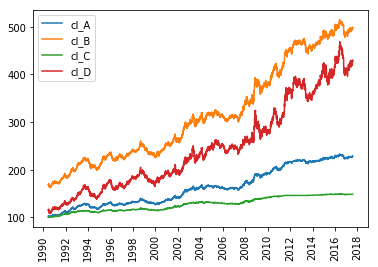

In [427]:
fig,ax = plt.subplots()
ax.plot(A["date"][a:b],A[a:b]['cl_A'])
ax.plot(B["date"][a:b],B[a:b]['cl_B'])
ax.plot(C["date"],C['cl_C'])
ax.plot(D["date"][3135:9964],D[3135:9964]['cl_D'])
ax.xaxis.set_major_locator(mdates.YearLocator(2,month = 2,day = 2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.legend()
_=plt.xticks(rotation=90) 
plt.show()

We observe a very strong relationship between the series op_B and op_D. To be sure we calculate correlations between the returns (or in this case day to day changes) between the series. 

More precisely, for each asset, we create a data frame which captures the day to day change in price of each asset. This is necessary because estimates (Auto Correlations and Cross Correlations) are usually possible only for stationary series. 

In [428]:
A_ret = A.copy()
del(A_ret['date'])
A_ret = A_ret.pct_change()
A_ret = A_ret.dropna(axis = 0)

B_ret = B.copy()
del(B_ret['date'])
B_ret = B_ret.pct_change()
B_ret = B_ret.dropna(axis = 0)

C_ret = C.copy()
del(C_ret['date'])
C_ret = C_ret.pct_change()
C_ret = C_ret.dropna(axis = 0)

D_ret = D.copy()
del(D_ret['date'])
D_ret = D_ret.pct_change()
D_ret = D_ret.dropna(axis = 0)


We create a database that includes all the data from the 4 series A,B,C and D. We study the correlations between series. 

In [429]:
returns = A_ret.join(B_ret,how = 'inner')
returns = returns.join(C_ret,how = "inner")
returns = returns.join(D_ret,how = 'inner')

In [430]:
# We name the columns of return appropriately

l = []
for j in list(returns.columns):
    j = j + '_ret'    
    l.append(j)
returns.columns = l    

In [432]:
correlations_op = returns[['cl_A_ret','cl_B_ret','cl_C_ret','cl_D_ret']].corr()
print(correlations_op)

          cl_A_ret  cl_B_ret  cl_C_ret  cl_D_ret
cl_A_ret  1.000000  0.945473  0.823172  0.848949
cl_B_ret  0.945473  1.000000  0.754613  0.929732
cl_C_ret  0.823172  0.754613  1.000000  0.643761
cl_D_ret  0.848949  0.929732  0.643761  1.000000


We observe a very strong relation between A and B as well as D and B. The correlation matrix suggests that
all four assets are 
closely related to each other. 

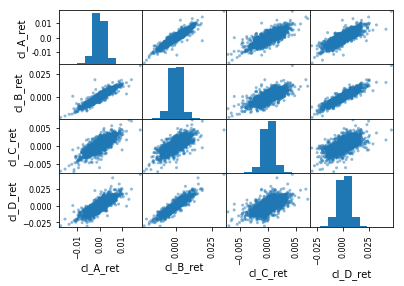

In [433]:
scatter_matrix(returns[['cl_A_ret','cl_B_ret','cl_C_ret','cl_D_ret']])
plt.show()

The scatter matrix suggest that there is a linear relationship between closing price data 
of the four assets.

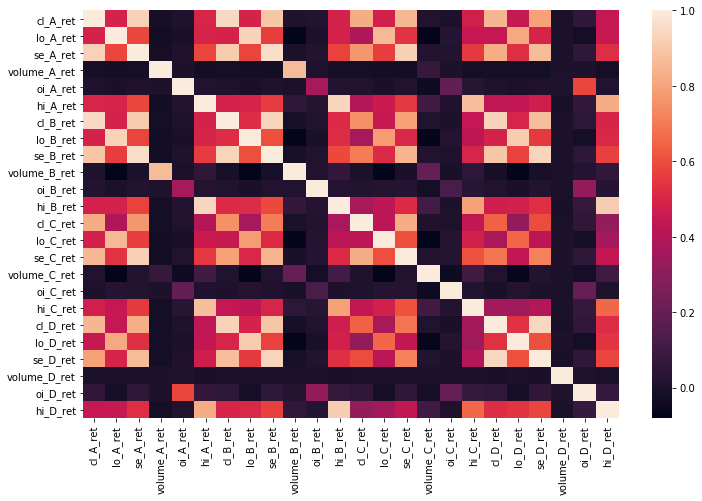

In [434]:
dims = (12,7.5)
fig,ax = plt.subplots(figsize = dims)
correlations = returns.corr()
sns.heatmap(ax = ax, data = correlations)
plt.show()
plt.savefig('correlation_matrix.png')

We make the following observations : 

1) The volume changes and changes in open interest from day to day show little correlation with the day to day changes of the other features (hi_ret,lo_ret,se_ret,op_ret) within the same series and
the other series.

2) For any two series, say A and B, we have strong correlations between cl_A_ret and cl_B_ret, hi_A_ret and hi_B_ret,
lo_A_ret and lo_B_ret, se_A_ret and se_B_ret. 

#  Functions we will use : 

We now list the functions we will call subsequently to process the data, clean it and also build models for it. 

# Preprocessing functions :

In [435]:
#Rename the columns so that they differ from those of A

def add_ret(B):
    t = []
    for j in list(B.columns):
        j = j + '_ret'    
        t.append(j)
    B.columns = t

In [436]:
#Function to correct missing values and outliers in a given entry of a column in a dataframe.

def insert_mean(S,i):
    S[i] = (S[i-1]+S[i+1])/2

In [437]:
"""Function checks for missing values and then fills them in."""

def rectify(df):
    cols = list(df.columns)
    for c in cols:
         S = df[c]
         nl = []
         A = S.isnull()
         for j in range(len(A)):
              if A[j] == True:
                nl.append(j)
         for j in nl:
             insert_mean(S,j)

In [438]:
"""check if series is random walk or not. Necessary since in 
many cases we are restricted to working with stationary series."""
def ad_fuller_test(S):
    results = adfuller(S)
    print("The p-value is " + str(results[1]))

In [439]:
"""function to plot the cross correlation for stationary series X and Y."""

def CCF(X,Y,s1):
    cross_corr = ccf(X,Y)
    plt.plot(cross_corr[0:250])
    plt.xlabel(s1)
    plt.show()

# Functions to build and test models :

We begin by building ARIMA models to get a measure of how noisy the various series are. 

In [532]:
"""The following function acts on a given time series and builds a ARIMA models at several parameter values.
It then outputs the AIC and BIC scores. We use these scores to choose a suitable model at a later stage.
In our case, we restrict our attention to just 5 ARIMA models and find that in some cases reasonable
accuracy can be achieved with this."""

def ARIMA_fitting_AIC_BIC_list(A):
    X = A.values
    size = int(len(X)*0.80)
    train = X[0:size]
    test = X[size:len(X)]
    AIC = []
    BIC = []
    for i in range(1,6):
        model = ARIMA(train,order = (i,1,0))
        model_fit = model.fit(disp=0)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
    print('The AIC list is ' )
    print(AIC)
    print('The BIC list is ')
    print(BIC)

In [533]:
"""Given an ARIMA(p,d,q)-model, we test its predictive power by means of a rolling forecast. This function inputs 
a time series and the parameters of an ARIMA model and outputs a test series and predictions which the model makes."""

def ARIMA_rolling_forecast(A,p,d,q):
    X = A.values
    size = int(len(X)*0.80)
    train = X[0:size]
    test = X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    return(test, predictions) 

In [442]:
"""We plot the predictions from the rolling forecast."""

def plot_predictions(test,predictions):
    plt.plot(predictions)
    plt.plot(test)
    plt.xlabel('Index of data point of test set')
    plt.ylabel('price')
    plt.legend()
    plt.show()

In [443]:
"""Mean squared error calculation"""

def MSE(test,predictions):
    error = mean_squared_error(test,predictions)
    return(error)
    #print(error)

In [444]:
"""The mean squared error might be misleading in this case. We hence define the mean absolute scaled error. 
The MASE tells us how much better or worse the given model is when compared to the very naive model which predicts
tomorrows value as todays value. An MASE which is greater than 1 implies that the model is worse than the naive model
while an MASE which is less than 1 implies that the model is better."""

def MASE(test,predictions):
    err = [test[j] - predictions[j] for j in range(len(test))]
    #Naive error calculation : 
    T = len(test)
    naive_error = 0
    for j in range(1,T):
        naive_error = naive_error + abs(test[j] - test[j-1])
    naive_error = (1/(T-1))*naive_error 
    scaled_errors = [x*naive_error for x in err]
    MASE = np.mean([abs(x) for x in scaled_errors])
    #print("The mean absolute scaled error is " + str(MASE))
    return(MASE)

We now build VAR models to make full use of the given data.

In [445]:
"""Function inputs a dataframe and a list of columns, and outputs a list of AIC and BIC scores for VAR(p) models 
(where p is the lag parameter). The columns indicated must be stationary series.""" 

def selecting_model(df,l):
    size = int(len(df)*0.7)
    data = df[l][0:size]
    model = VAR(data)
    return(model.select_order(30))

In [502]:
"""We test our VAR model using a rolling forecast. The input data is df - a dataframe, a list of columns
which are the set of variables of interest. The function outputs a test series and a prediction series.
An important point to note is that VAR models can only work with stationary series."""

def VAR_rolling_forecast(df,l,p,split):
    size = int(len(df)*split)
    predictions = list()
    test = []
    while size <= len(df)-1:
        data = df[0:size][l]
        model = VAR(data)
        model_fit = model.fit(p)
        output = model_fit.forecast(data.values,1)
        yhat = output[0][0]
        predictions.append(yhat)
        test.append(df[l[0]][size])
        size = size + 1
    return(test,predictions)

In [447]:
"""This is similar to the function above. We will use it when we build a model using multiple series as input data. 
For instance both A and B...In the function below, l is a list of column names, p is the lag parameter for the VAR model, h is the 
maximum amount of time in the future for which you wish to forecast, l1 is the list of columns which you 
wish to predict for. The output in this case are two dictionaries - one called test and the other called 
predictions."""

def VAR_rolling_forecast_general(df,l,p,l1,h):
    size = int(len(df)*0.70)
    predictions = {}
    test = {}
    for i in range(1,h+1):
        for j in l1:
            predictions[(j,i)] = []
            test[(j,i)] = []
    while size <= len(df)-h:
          data = df[0:size][l]
          model = VAR(data)
          model_fit = model.fit(p)
          output = model_fit.forecast(data.values,h)
          for j in l1:
            for i in range(1,h+1):
                k = l.index(j)
                yhat = output[i-1][k]
                predictions[(j,i)].append(yhat)
                test[(j,i)].append(df[j][size + i - 1])
          size = size + 1
    return(test,predictions)

In [314]:
"""Since the VAR model predicts the stationary returns series, we write a function
that recovers predictions for the original series."""

def recover_asset_predictions(S,size,test,predictions):
    test_adj = []
    for j in range(size+1,len(S)):
        test_adj.append(S[j])
    predictions_adj = []
    j = size
    t = 0
    while t <= len(predictions)-1 and j <= len(S)-1:
        predictions_adj.append(S[j]*(predictions[t]+1))
        t = t + 1
        j = j + 1
    return(test_adj,predictions_adj)

# We predict the opening prices of asset A.

We start by plotting the autocorrelation function for the returns series - A_ret

In [449]:
A_ret.describe()

,cl_A,lo_A,se_A,volume_A,oi_A,hi_A
count,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000
mean,0.000112,0.000112,0.000112,inf,0.007094,0.000112
std,0.002599,0.002385,0.002519,NaN,0.391756,0.002468
min,-0.017423,-0.017679,-0.019006,-1.000000,-0.971345,-0.016938
25%,-0.001341,-0.001093,-0.001258,-0.231088,-0.009297,-0.001113
50%,0.000141,0.000146,0.000128,0.002941,0.001130,0.000063
75%,0.001582,0.001363,0.001529,0.309608,0.013352,0.001366
max,0.018204,0.015206,0.019735,inf,33.385878,0.019126


In [450]:
add_ret(A_ret)

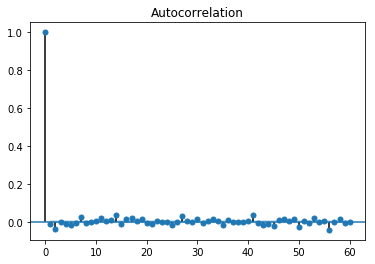

In [451]:
plot_acf(A_ret['cl_A_ret'],lags = 60,alpha = 0.5)

It looks like the series is a white noise process because we do not see any non trivial auto correlations beyond lag 0. 

We make test quickly if this observation is accurate using the Dicky-Fuller test on the series A_ret. 

In [453]:
ad_fuller_test(A['cl_A'])

The p-value is 0.950321143027


The test implies that A is a random walk. 

We fit ARIMA(p,d,q) models to predict the opening price of the asset A given its previous opening prices. 

We begin by finding the most suitable p,d and q using the AIC and BIC scores. 

In [454]:
ARIMA_fitting_AIC_BIC_list(A['cl_A'])

The AIC list is 
[4965.888812146244, 4959.764469992173, 4961.644096187485, 4954.598240368605, 4956.463551272969]
The BIC list is 
[4985.5551678568445, 4985.9862776063064, 4994.4213557051517, 4993.9309517898046, 5002.3517145977021]


The AIC and BIC scores tell us that a ARIMA(2,1,0) is a reasonable choice to make. We compute the MSE of the ARIMA(2,1,0) model as follows and find that on average the model has an error of 0.2024 using a Rolling forecast. 

Rolling forecast error calculation :

In [148]:
testA,predictions_A210 = ARIMA_rolling_forecast(A['cl_A'],2,1,0)

/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


We see in the graph below that the predictions follow the test data almost perfectly. 

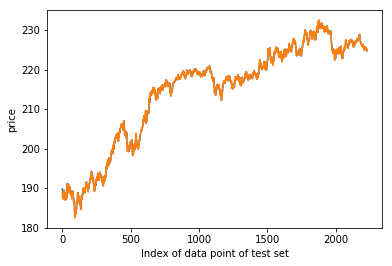

In [50]:
plot_predictions(testA,predictions_A210)

In [47]:
MSE(testA,predictions_A210)

0.202857272149


We calculate the mean absolute scaled error so as to be able to compare the models for the different series. 

In [48]:
MASE(testA,predictions_A210)

The mean absolute scaled error is 0.115669239301


We also test an ARIMA(5,1,0) model.

In [51]:
testA,predictions_A510 = ARIMA_rolling_forecast(A['op_A'],5,1,0)  

/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [54]:
MSE(testA,predictions_A510)

0.203271100825


In [55]:
MASE(testA,predictions_A510)

The mean absolute scaled error is 0.11575193168


# VAR models for closing price of asset A

# We predict the closing price of asset B

We will study the returns dataframe associated to the asset B. Before doing so,
we make minor adjustments to the dataframe B.

In [455]:
mean_volume_B = B['volume_B'].mean()
B['volume_B']= B.volume_B.mask(B.volume_B == 0,mean_volume_B)
mean_oi_B = B['oi_B'].mean()
B['oi_B']= B.oi_B.mask(B.oi_B == 0,mean_oi_B)

In [456]:
"""Since we have changed the dataframe D, we redefine D_ret"""
B_ret = B.copy()
del(B_ret['date'])
B_ret = B_ret.pct_change()
B_ret = B_ret.dropna(axis = 0)

In [457]:
B_ret.describe()

,cl_B,lo_B,se_B,volume_B,oi_B,hi_B
count,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000
mean,0.000188,0.000187,0.000187,0.243783,0.020019,0.000186
std,0.004550,0.003997,0.004231,7.118005,1.625826,0.004039
min,-0.030137,-0.025499,-0.024001,-0.998411,-0.992675,-0.022499
25%,-0.002288,-0.001829,-0.002102,-0.225134,-0.010818,-0.001830
50%,0.000126,0.000276,0.000150,0.004957,0.001439,0.000118
75%,0.002668,0.002230,0.002513,0.303968,0.014950,0.002216
max,0.044639,0.042678,0.036305,645.428571,153.604520,0.035004


We observe that the standard deviation of the feature volume_B is 
larger than the other features. 

In [458]:
add_ret(B_ret)

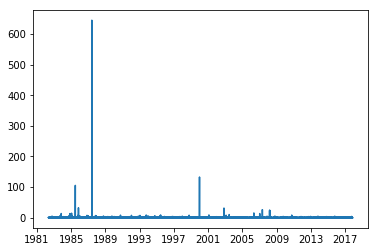

In [461]:
plt.plot(B_ret['volume_B_ret'])
plt.show()

We observe certain anomalies in the volume data and try to identify the precise points at which these anomalies occurred. 

In [462]:
outliersB = []
for j in range(len(B_ret)):
    if B_ret['volume_B_ret'][j] > 100:
        outliersB.append(j)
print(outliersB)  

[797, 1285, 4454]


There are two days which had significant volume changes - 05/06/1985 - 645%, 28/06/2001 - 132%. We consider these extreme outliers and hence alter the information here by replace the values with the mean of the volume changes of the days before and after. 

In [463]:
for j in outliersB:
    B_ret['volume_B_ret'][j] = B_ret['volume_B_ret'].mean()

In [464]:
B_ret.describe()

,cl_B_ret,lo_B_ret,se_B_ret,volume_B_ret,oi_B_ret,hi_B_ret
count,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000
mean,0.000188,0.000187,0.000187,0.145215,0.020019,0.000186
std,0.004550,0.003997,0.004231,0.992099,1.625826,0.004039
min,-0.030137,-0.025499,-0.024001,-0.998411,-0.992675,-0.022499
25%,-0.002288,-0.001829,-0.002102,-0.225134,-0.010818,-0.001830
50%,0.000126,0.000276,0.000150,0.004957,0.001439,0.000118
75%,0.002668,0.002230,0.002513,0.303225,0.014950,0.002216
max,0.044639,0.042678,0.036305,32.110540,153.604520,0.035004


We plot the ACF for the returns series of B which is stationary. 

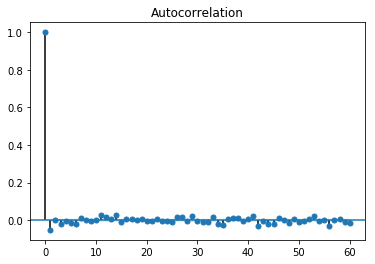

In [466]:
plot_acf(B_ret['cl_B_ret'],lags = 60,alpha = 0.5)

In [468]:
ad_fuller_test(B['cl_B'])

The p-value is 0.962604036252


It is extremely likely that B is a random walk.

In [534]:
ARIMA_fitting_AIC_BIC_list(B['cl_B'])

The AIC list is 
[21541.39964972225, 21531.6183016243, 21533.617490389217, 21534.75229594119, 21535.181237305533]
The BIC list is 
[21562.030539743038, 21559.126154985352, 21568.00230709053, 21576.014075982763, 21583.319980687367]


Selection in this case is slightly more difficult. We choose the ARIMA(1,1,0) model. We will also test the ARIMA(4,1,0) model and the ARIMA(2,1,0) model. 

In [535]:
testB,predictions_B110 = ARIMA_rolling_forecast(B['cl_B'],1,1,0)

/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


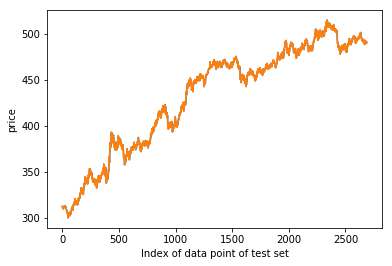

In [65]:
plot_predictions(testB,predictions_B110)

In [536]:
errorB110 = mean_squared_error(testB,predictions_B110)
print(errorB110)

2.28790773263


In [537]:
MASE(testB,predictions_B110)

1.3287768547097691

We see that the mean absolute scaled error in this case indicates that the model performs WORSE than 
a model which predicts tomorrows opening price as todays price. To be sure we employ an ARIMA(2,1,0) model as well. 

In [66]:
testB,predictions_B210 = ARIMA_rolling_forecast(B['op_B'],2,1,0)

/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


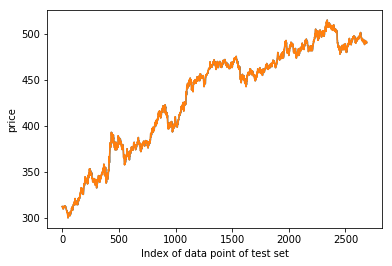

In [67]:
plot_predictions(testB,predictions_B210)

 We calculate the MSE below.

In [69]:
errorB210 = mean_squared_error(testB,predictions_B210)
print(errorB210)

2.6832802102


In [71]:
MASE(testB,predictions_B210)

The mean absolute scaled error is 1.54671884084


# VAR models for asset B

To reduce the scaled error, we look to fit VAR models for the asset B. 

In [73]:
#CCF(B_ret['op_B_ret'],B_ret['hi_B_ret'],'op_B_ret vs hi_B_ret')
#CCF(B_ret['op_B_ret'],B_ret['lo_B_ret'],'op_B_ret vs lo_B_ret')

We begin by selecting a suitable model for prediction. We do so by selecting according to the BIC score. 

In [471]:
selecting_model(B_ret,['cl_B_ret','hi_B_ret', 'lo_B_ret', 'se_B_ret', 'volume_B_ret', 'oi_B_ret'])

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -44.52       -44.51    4.636e-20       -44.52
1        -46.53       -46.49    6.192e-21       -46.52
2        -46.96       -46.88    4.018e-21       -46.93
3        -47.19       -47.06    3.213e-21       -47.14
4        -47.31       -47.14    2.855e-21       -47.25
5        -47.39       -47.19    2.613e-21       -47.32
6        -47.46       -47.22    2.436e-21       -47.38
7        -47.51       -47.23    2.324e-21       -47.41
8        -47.55      -47.23*    2.232e-21       -47.44
9        -47.58       -47.22    2.176e-21       -47.45
10       -47.60       -47.20    2.134e-21       -47.46
11       -47.61       -47.18    2.104e-21       -47.46
12       -47.62       -47.15    2.078e-21       -47.46
13       -47.64       -47.13    2.036e-21      -47.47*
14       -47.65       -47.10    2.013e-21       -47.46
15       -

{'aic': 28, 'bic': 8, 'fpe': 28, 'hqic': 13}

We now write a function that tests the model using a rolling forecast for the given data. 

** Make sure the date column has already been removed.

** Make sure the first element of the list l is the column 'cl_B_ret'

In [520]:
l = ['cl_B_ret','hi_B_ret', 'lo_B_ret', 'se_B_ret', 'volume_B_ret', 'oi_B_ret']
testB, predictions_BVAR8 = VAR_rolling_forecast(B_ret,l,8,split = 0.8)

In [523]:
size = int(len(B_ret)*0.8)
testB_adj,predictions_BVAR8_adj = recover_asset_predictions(B['cl_B'],size,testB,predictions_BVAR8)

In [524]:
MSE(testB_adj,predictions_BVAR8_adj)

2.6895981562577123

In [525]:
MASE(testB_adj,predictions_BVAR8_adj)

1.5508086957661149

We find that the scores obtained are not better than the previous ARIMA(1,1,0) model. It follows that we must change 
our approach when tuning the hyper-parameter p. We split into three segments [0:a], [a+1:b] and [b+1:]. For a given p, 
we fit a VAR(p) on the data in the segment [0:a] and then test this on [a+1:b]. We then choose the best 
such p and test on [b+1:]. We choose 'a' so that the segment [0:a] represents roughly 64% of the data, and we choose 
'b' so that [b+1,:] contains approximates 20% of the data. 

In [528]:
MASE_list = []
MSE_list = []
for p in range(1,4):
    size1 = int(len(B_ret)*.8)
    test, predictions = VAR_rolling_forecast(B_ret[0:size1],l,p,0.8) 
    size = int(len(B_ret[0:size1])*0.80)
    test,predictions = recover_asset_predictions(B[0:size1+1]['cl_B'],size,test,predictions) 
    MSE_list.append(MSE(test,predictions))
    MASE_list.append(MASE(test,predictions))

In [529]:
MSE_list

[2.4541430808865923, 2.4491812805290376, 2.4691141199200737]

In [530]:
MASE_list

[1.3079395063537453, 1.3069516930305969, 1.3122660031816051]

We see that the VAR(2) model outperforms the other models. We test this model on the remaining data. 

In [531]:
test, predictions = VAR_rolling_forecast(B_ret,l,3,0.8) 
size = int(len(B_ret)*0.80)
test,predictions = recover_asset_predictions(B['cl_B'],size,test,predictions) 
print("The MSE is" + str(MSE(test,predictions)))
print("The MASE is" + str(MASE(test,predictions)))

The MSE is2.27941438888
The MASE is1.32404913499


We see that we marginally beat the previous ARIMA scores.  

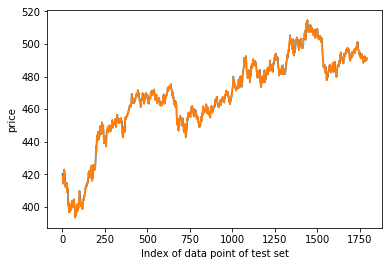

In [540]:
plot_predictions(test,predictions)

# We predict the opening price of asset C

In [92]:
C_ret.describe()

,op_C,hi_C,lo_C,se_C,volume_C,oi_C,cl_C
count,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000
mean,0.000058,0.000058,0.000058,0.000058,0.274278,0.002201,0.000059
std,0.001083,0.001025,0.000985,0.001021,1.521008,0.051717,0.001083
min,-0.007143,-0.007571,-0.009263,-0.009231,-0.984305,-0.315962,-0.007143
25%,-0.000461,-0.000383,-0.000385,-0.000430,-0.290468,-0.009697,-0.000461
50%,0.000000,0.000000,0.000000,0.000000,-0.000942,0.001623,0.000000
75%,0.000587,0.000478,0.000502,0.000546,0.406833,0.014493,0.000587
max,0.007069,0.009767,0.007599,0.008664,56.071429,0.489942,0.007069


In [94]:
add_ret(C_ret)

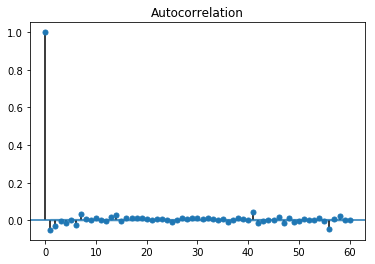

In [95]:
plot_acf(C_ret['op_C_ret'],lags = 60,alpha = 0.5)

In [97]:
ad_fuller_test(C['op_C'])

The p-value is 0.493232730647


We see that the p-value indicates that there is a high chance that C is a random walk. 

In [98]:
ARIMA_fitting_AIC_BIC_list(C['op_C'])

The AIC list is 
[-4503.827592841331, -4507.7979488948695, -4506.2245057312175, -4507.27249312184, -4505.339098590113]
The BIC list is 
[-4484.4141450825873, -4481.9133518832105, -4473.8687594666435, -4468.445597604351, -4460.0410538197093]


In [99]:
testC,predictions_C210 = ARIMA_rolling_forecast(C['op_C'],2,1,0)

/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


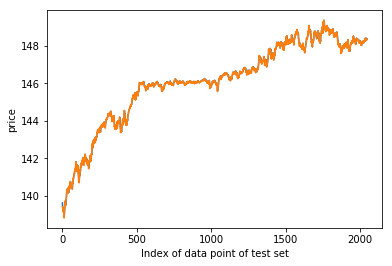

In [215]:
plot_predictions(testC,predictions_C210)

In [101]:
errorC210 = mean_squared_error(testC,predictions_C210)
print(errorC210)

0.00656176273054


In [102]:
MASE(testC,predictions_C210)

The mean absolute scaled error is 0.00338127179786


# We predict the opening price of asset D

In [238]:
D.isnull().sum()

op_D        0
hi_D        0
lo_D        0
se_D        0
volume_D    0
oi_D        0
cl_D        0
dtype: int64

In [239]:
D = D.fillna(D.mean())

In [240]:
mean_volume_D = D['volume_D'].mean()
D['volume_D']= D.volume_D.mask(D.volume_D == 0,mean_volume_D)
mean_oi_D = D['oi_D'].mean()
D['oi_D']= D.oi_D.mask(D.oi_D == 0,mean_oi_D)

In [242]:
"""Since we have changed the dataframe D, we redefine D_ret"""
D_ret = D.copy()
#del(D_ret['date'])
D_ret = D_ret.pct_change()
D_ret = D_ret.dropna(axis = 0)

In [275]:
add_ret(D_ret)

In [276]:
D_ret.describe()

,op_D_ret,hi_D_ret,lo_D_ret,se_D_ret,volume_D_ret,oi_D_ret,cl_D_ret
count,10025.000000,10025.000000,10025.000000,10025.000000,1.002500e+04,1.002500e+04,10025.000000
mean,197.990304,198.939518,197.073666,198.018118,4.550210e+05,4.020358e+05,198.022780
std,107.466877,107.998376,106.962034,107.485478,3.369490e+05,2.490640e+05,107.486463
min,53.865881,54.746936,53.622831,54.260836,1.455910e+00,1.046000e+03,53.865881
25%,108.805716,109.311566,108.344512,108.893283,1.949484e+05,2.073000e+05,108.818080
50%,175.008819,175.656260,174.202253,174.973440,4.250980e+05,3.957730e+05,175.011987
75%,258.347324,259.588715,257.029087,258.183413,6.586967e+05,5.974220e+05,258.372188
max,468.497084,469.158453,464.611543,468.083729,3.299994e+06,1.711428e+06,468.497084


We observe that the feature 'volume_D_ret' has some issues with it, in that the standard deviation is extremely 
large compared to the mean. 

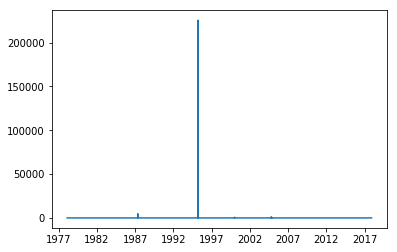

In [192]:
plt.plot(D_ret['volume_D_ret'])
plt.show()

In [193]:
outliers = []
for j in range(len(D_ret)):
    if D_ret['volume_D_ret'][j] > 100:
        outliers.append(j)
print(outliers)        

[2328, 4315, 5516, 6716, 6739]


In [194]:
for j in outliers:
    D_ret['volume_D_ret'][j] = D_ret['volume_D_ret'].mean()

In [195]:
D_ret.describe()

,op_D_ret,hi_D_ret,lo_D_ret,se_D_ret,volume_D_ret,oi_D_ret,cl_D_ret
count,10024.000000,10024.000000,10024.000000,10024.000000,10024.000000,10024.000000,10024.000000
mean,0.000173,0.000166,0.000165,0.000169,0.153686,0.004048,0.000173
std,0.007566,0.006482,0.006487,0.007047,1.140311,0.147295,0.007566
min,-0.059296,-0.047258,-0.040884,-0.032905,-0.999998,-0.930381,-0.059296
25%,-0.003911,-0.003042,-0.003031,-0.003646,-0.222217,-0.012464,-0.003911
50%,0.000277,0.000000,0.000277,0.000273,0.003471,0.000871,0.000277
75%,0.004269,0.003420,0.003440,0.004084,0.297586,0.016027,0.004269
max,0.059129,0.053608,0.049610,0.040624,52.438596,11.905247,0.059129


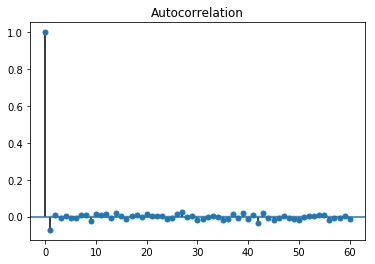

In [196]:
plot_acf(D_ret['op_D_ret'],lags = 60,alpha = 0.5)

In [197]:
ARIMA_fitting_AIC_BIC_list(D['op_D'])

The AIC list is 
[19568.046089126517, 19569.72591228275, 19570.395459004045, 19572.08550001464, 19574.076109728492]
The BIC list is 
[19588.613934728673, 19597.149706418957, 19604.675201674305, 19613.221191218952, 19622.067749466856]


In [198]:
testD, predictions_D110 = ARIMA_rolling_forecast(D['op_D'],1,1,0)

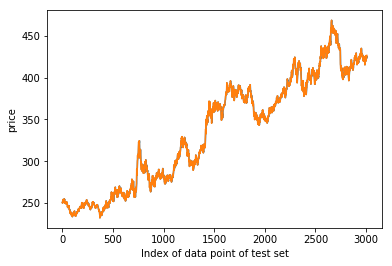

In [207]:
plot_predictions(testD,predictions_D110)

In [203]:
MSE(testD,predictions_D110)

5.05740953847


In [204]:
MASE(testD,predictions_D110)

The mean absolute scaled error is 2.83227648473


The MASE indicates that the ARIMA model is a very poor predictor in this case. 

# VAR models for asset D

In [274]:
add_ret(D_ret)

,op_D,hi_D,lo_D,se_D,volume_D,oi_D,cl_D
date,,,,,,,
1978-02-14,100.032467,100.064934,99.773147,100.000000,209.530092,1046.0,99.967637
1978-02-15,99.967637,99.967637,99.708318,99.773147,236.499312,1149.0,99.448998
1978-02-16,99.448998,99.546295,99.319338,99.416635,290.437752,1218.0,99.708318
1978-02-17,99.708318,99.805614,99.513828,99.805614,350.599858,1200.0,99.675954
1978-02-21,99.675954,99.708318,99.448998,99.481361,276.953142,1323.0,99.481361


In [277]:
selecting_model(D_ret,['cl_D_ret','hi_D_ret', 'lo_D_ret', 'se_D_ret', 'volume_D_ret', 'oi_D_ret'])

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         50.26        50.26    6.696e+21        50.26
1         36.16        36.20    5.072e+15        36.18
2         36.02        36.10    4.405e+15        36.05
3         35.95        36.06    4.105e+15        35.99
4         35.89        36.04    3.854e+15        35.94
5         35.82       36.00*    3.594e+15        35.88
6         35.80        36.02    3.530e+15       35.87*
7         35.79        36.04    3.501e+15        35.88
8         35.79        36.07    3.480e+15        35.89
9         35.77        36.10    3.437e+15        35.88
10        35.76        36.12    3.407e+15        35.89
11        35.76        36.16    3.397e+15        35.90
12        35.76        36.19    3.406e+15        35.91
13        35.76        36.23    3.403e+15        35.92
14        35.76        36.26    3.396e+15        35.93
15        

{'aic': 25, 'bic': 5, 'fpe': 25, 'hqic': 6}

In [209]:
lD = ['cl_D_ret','hi_D_ret', 'lo_D_ret', 'se_D_ret', 'volume_D_ret', 'oi_D_ret']
testD, predictions_DVAR8 = VAR_rolling_forecast(D_ret,lD,5)

In [210]:
MASE(testD,predictions_DVAR8)

The mean absolute scaled error is 3.64249326058e-05


This a tremendous improvement in MASE from before indicating that the more VAR model outperforms
the naive model considerably.

In [211]:
MSE(testD,predictions_DVAR8)

4.43115952535e-05


In [217]:
size = int(len(D_ret)*0.70)
testD_adj,predictions_DVAR8_adj = recover_asset_predictions(D['cl_D'],size,testD,predictions_DVAR8)

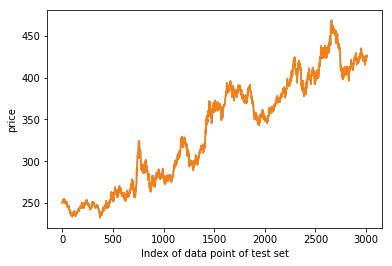

In [219]:
plot_predictions(testD_adj,predictions_DVAR8_adj)

# Joint VAR models for B and D

In [225]:
del(D['date'])

In [224]:
del(B['date'])

In [265]:
BD = pd.concat([B,D],axis = 1,join = 'inner')

In [266]:
BD.describe()

,op_B,hi_B,lo_B,se_B,volume_B,oi_B,cl_B,op_D,hi_D,lo_D,se_D,volume_D,oi_D,cl_D
count,8958.000000,8958.000000,8958.000000,8958.000000,8.958000e+03,8.958000e+03,8958.000000,8958.000000,8958.000000,8958.000000,8958.000000,8.958000e+03,8.958000e+03,8958.000000
mean,278.347689,279.155382,277.575751,278.383074,1.515650e+06,9.307285e+05,278.391427,211.947419,212.960079,210.973260,211.982228,5.070480e+05,4.465881e+05,211.988048
std,117.200014,117.482333,116.935893,117.216474,1.947028e+06,9.586177e+05,117.206232,105.147878,105.678383,104.640246,105.160036,3.185828e+05,2.247977e+05,105.159865
min,95.292938,95.598085,94.900607,95.380123,4.711110e+01,3.540000e+02,95.292938,56.797338,57.187801,56.527018,57.007588,1.455910e+00,3.831000e+03,56.797338
25%,173.717596,174.125397,173.334473,173.739709,4.372357e+04,7.742750e+04,173.735252,120.284422,120.749235,119.846912,120.276475,2.750221e+05,2.590438e+05,120.309910
50%,242.191170,242.753633,241.629628,242.162762,3.097504e+05,5.022365e+05,242.239978,186.171560,186.984460,185.484292,186.206348,4.678112e+05,4.321430e+05,186.189118
75%,367.077548,368.200222,365.224981,366.941840,2.799319e+06,1.688212e+06,367.176244,273.705867,275.697100,272.439932,274.137797,6.912303e+05,6.180605e+05,273.790591
max,514.614582,516.056248,513.533333,514.734721,1.638990e+07,3.314445e+06,514.614582,468.497084,469.158453,464.611543,468.083729,3.299994e+06,1.711428e+06,468.497084


In [267]:
"""Since we have changed the dataframe D, we redefine D_ret"""
BD_ret = BD.copy()
#del(BD_ret['date'])
BD_ret = BD_ret.pct_change()
BD_ret = BD_ret.dropna(axis = 0)

In [268]:
add_ret(BD_ret)

In [301]:
BD_ret.describe()

,op_B_ret,hi_B_ret,lo_B_ret,se_B_ret,volume_B_ret,oi_B_ret,cl_B_ret,op_D_ret,hi_D_ret,lo_D_ret,se_D_ret,volume_D_ret,oi_D_ret,cl_D_ret
count,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000
mean,0.000189,0.000186,0.000187,0.000187,0.243783,0.020019,0.000188,0.000242,0.000235,0.000236,0.000238,25.931615,0.003321,0.000240
std,0.004552,0.004039,0.003997,0.004231,7.118005,1.625826,0.004550,0.006867,0.006040,0.006009,0.006593,2382.648750,0.138329,0.006865
min,-0.030137,-0.022499,-0.025499,-0.024001,-0.998411,-0.992675,-0.030137,-0.036593,-0.039023,-0.040884,-0.031618,-0.999998,-0.930381,-0.036593
25%,-0.002288,-0.001830,-0.001829,-0.002102,-0.225134,-0.010818,-0.002288,-0.003751,-0.002820,-0.002826,-0.003480,-0.224584,-0.012050,-0.003751
50%,0.000127,0.000118,0.000276,0.000150,0.004957,0.001439,0.000126,0.000314,0.000223,0.000301,0.000299,0.003614,0.000721,0.000311
75%,0.002670,0.002216,0.002230,0.002513,0.303968,0.014950,0.002668,0.004254,0.003372,0.003472,0.004079,0.301033,0.015275,0.004254
max,0.044639,0.035004,0.042678,0.036305,645.428571,153.604520,0.044639,0.051905,0.053608,0.049610,0.040624,225446.000000,11.905247,0.051905


In [279]:
l_BD = l + lD
h = l_BD[1]
l_BD[1] = l_BD[6]
l_BD[6] = h

In [278]:
selecting_model(BD_ret,l_BD)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -81.42       -81.41    4.367e-36       -81.41
1        -84.79       -84.62    1.501e-37       -84.73
2        -85.63       -85.30    6.489e-38       -85.52
3        -86.06       -85.58    4.203e-38       -85.90
4        -86.28       -85.64    3.394e-38       -86.06
5        -86.45       -85.66    2.860e-38       -86.17
6        -86.59       -85.64    2.491e-38       -86.26
7        -86.66       -85.56    2.304e-38       -86.28
8        -86.76       -85.50    2.095e-38       -86.32
9        -86.81       -85.39    1.999e-38       -86.32
10       -86.84       -85.27    1.932e-38       -86.30
11       -86.85       -85.13    1.903e-38       -86.26
12       -86.87       -84.99    1.876e-38       -86.22
13       -86.90       -84.87    1.819e-38       -86.20
14       -86.93       -84.74    1.764e-38       -86.17
15       -

{'aic': 21, 'bic': 19, 'fpe': 21, 'hqic': 19}

In [280]:
testBD_B, predictions_BDVAR19_B = VAR_rolling_forecast(BD_ret,l_BD,19)

In [281]:
MASE(testBD_B,predictions_BDVAR19_B)

The mean absolute scaled error is 1.30947790309e-05


We observe that with the added data, the VAR model to predict the closing prices of asset B is worse
than the model employed previously using just the data for asset B. 

In [283]:
MSE(testBD_B,predictions_BDVAR19_B)

1.64184086156e-05


In [289]:
len(list(BD.columns))

14

# Dimension reduction for the joint dataframe BD

In [290]:
pca_BD = PCA(n_components = 7)


In [302]:
BD_ret.head()

,op_B_ret,hi_B_ret,lo_B_ret,se_B_ret,volume_B_ret,oi_B_ret,cl_B_ret,op_D_ret,hi_D_ret,lo_D_ret,se_D_ret,volume_D_ret,oi_D_ret,cl_D_ret
date,,,,,,,,,,,,,,
1982-05-05,0.011853,0.004344,0.009670,0.001741,0.233079,0.181867,0.006941,0.011994,0.003450,0.012506,0.000000,0.127563,-0.030617,0.007407
1982-05-06,0.006941,0.010381,0.009142,0.014335,-0.332529,-0.126201,0.009910,0.007407,0.015717,0.006917,0.020237,0.288557,0.019630,0.017647
1982-05-07,0.009910,0.004281,0.005608,0.003854,-0.305745,0.003491,-0.002560,0.017647,0.005803,0.012267,0.002903,-0.038607,0.030767,-0.003372
1982-05-10,-0.002560,0.000426,0.001716,-0.001706,-0.351364,-0.003479,-0.002139,-0.003372,-0.003846,-0.002908,-0.003859,-0.147070,-0.015783,-0.005317
1982-05-11,-0.002139,0.000426,-0.001713,0.001709,0.261280,-0.050703,0.004286,-0.005317,0.003378,0.000000,0.003874,0.023531,0.044110,0.007289


In [310]:
BD_reduced_ret = pd.DataFrame(pca_BD.fit_transform(BD_ret[l_BD[1:]]))

In [311]:
pca_BD.explained_variance_ratio_

array([  9.99990606e-01,   9.35242353e-06,   3.78644812e-08,
         3.36785602e-09,   2.61819181e-11,   6.08737280e-12,
         3.44433354e-12])

In [313]:
temp = BD_ret['cl_B_ret']

In [314]:
BD_reduced_ret = BD_reduced_ret.assign(cl = temp.values)
BD_reduced_ret.rename(columns = {'cl':'cl_B_ret'},inplace = True)

In [323]:
BD_reduced_ret.index = BD_ret.index

In [328]:
l_BD_reduced = ['cl_B_ret',0,1,2,3,4,5,6]

In [331]:
pca_BD.singular_values_

array([  2.25484693e+05,   6.89574493e+02,   4.38768167e+01,
         1.30856670e+01,   1.15377158e+00,   5.56332019e-01,
         4.18477108e-01])

In [330]:
BD_reduced_ret.describe()

,0,1,2,3,4,5,6,cl_B_ret
count,8.957000e+03,8.957000e+03,8.957000e+03,8.957000e+03,8.957000e+03,8.957000e+03,8.957000e+03,8957.000000
mean,2.792115e-14,1.344241e-16,-2.390692e-18,-1.705866e-18,1.330166e-19,2.062127e-19,1.604334e-19,0.000188
std,2.382649e+03,7.286587e+00,4.636370e-01,1.382735e-01,1.219166e-02,5.878642e-03,4.421959e-03,0.004550
min,-2.693161e+01,-1.430389e+00,-1.175602e+01,-9.298101e-01,-5.538691e-02,-3.764540e-02,-4.435929e-02,-0.030137
25%,-2.615620e+01,-4.620810e-01,-8.430725e-02,-1.544837e-02,-6.709442e-03,-3.415204e-03,-2.361709e-03,-0.002288
50%,-2.592800e+01,-2.372647e-01,-3.216731e-02,-2.604399e-03,1.779473e-04,3.752015e-05,-1.294021e-04,0.000126
75%,-2.563058e+01,5.764358e-02,3.434891e-02,1.219308e-02,7.085713e-03,3.458686e-03,2.312325e-03,0.002668
max,2.254201e+05,6.631089e+02,2.836965e+01,1.189565e+01,1.005369e-01,4.084738e-02,4.567678e-02,0.044639


In [324]:
selecting_model(BD_reduced_ret,l_BD_reduced)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -27.00       -27.00    1.873e-12       -27.00
1        -28.83       -28.75    3.022e-13       -28.80
2        -29.21       -29.06    2.061e-13       -29.16
3        -29.39       -29.17    1.726e-13       -29.31
4        -29.48       -29.20    1.568e-13       -29.38
5        -29.54       -29.18    1.486e-13       -29.42
6        -29.57       -29.15    1.437e-13       -29.42
7        -29.60       -29.10    1.401e-13       -29.43
8        -29.62       -29.06    1.368e-13       -29.43
9        -29.63       -29.00    1.359e-13       -29.41
10       -29.64       -28.94    1.340e-13       -29.40
11       -29.64       -28.87    1.340e-13       -29.37
12       -29.64       -28.80    1.338e-13       -29.35
13       -29.65       -28.74    1.330e-13       -29.33
14       -29.65       -28.67    1.329e-13       -29.31
15       -

{'aic': 20, 'bic': 19, 'fpe': 20, 'hqic': 20}

In [332]:
testBD, predictions_BD_reduced_VAR3 = VAR_rolling_forecast(BD_reduced_ret,l_BD_reduced,3)

In [333]:
MASE(testBD,predictions_BD_reduced_VAR3)

The mean absolute scaled error is 1.29068322952e-05


In [ ]:
MSE5(testBD,predictions_BD_reduced_VAR3)

In [367]:
pca_BD2 =  PCA(9)

In [368]:
BD2_reduced_ret = pd.DataFrame(pca_BD2.fit_transform(BD_ret[[l_BD[0]] + l_BD[2:]]))

In [369]:
pca_BD2.explained_variance_ratio_

array([  9.99990606e-01,   9.35242353e-06,   3.78644799e-08,
         3.36785376e-09,   2.29602935e-11,   4.72855774e-12,
         3.44350962e-12,   9.42714726e-13,   4.86487848e-13])

In [370]:
temp1 = BD_ret['cl_D_ret']

In [371]:
BD2_reduced_ret = BD2_reduced_ret.assign(cl = temp1.values)
BD2_reduced_ret.rename(columns = {'cl':'cl_D_ret'},inplace = True)

In [372]:
l_BD2_reduced = ['cl_D_ret'] + list(range(9))

In [373]:
BD2_reduced_ret.index = BD_ret.index

In [374]:
selecting_model(BD2_reduced_ret,l_BD2_reduced)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -52.65       -52.63    1.369e-23       -52.64
1        -55.37       -55.25    9.013e-25       -55.32
2        -55.96       -55.73    4.990e-25       -55.88
3        -56.26       -55.93    3.685e-25       -56.14
4        -56.42       -55.97    3.157e-25       -56.26
5        -56.53       -55.98    2.823e-25       -56.34
6        -56.63       -55.97    2.556e-25       -56.40
7        -56.68       -55.92    2.412e-25       -56.42
8        -56.75       -55.87    2.263e-25       -56.44
9        -56.77       -55.79    2.203e-25       -56.43
10       -56.81       -55.71    2.137e-25       -56.43
11       -56.82       -55.62    2.110e-25       -56.40
12       -56.82       -55.52    2.098e-25       -56.37
13       -56.85       -55.43    2.051e-25       -56.36
14       -56.87       -55.34    2.008e-25       -56.34
15       -

{'aic': 21, 'bic': 19, 'fpe': 21, 'hqic': 20}

In [375]:
testBD2, predictions_BD2_reduced_VAR4 = VAR_rolling_forecast(BD2_reduced_ret,l_BD2_reduced,4)

In [376]:
MASE(testBD2, predictions_BD2_reduced_VAR4)

The mean absolute scaled error is 4.01276784653e-05


This is a reduction in the prediction score for the closing price of the asset D. 

In [218]:
residuals = pd.DataFrame(mod.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

NameError: name 'mod' is not defined

In [349]:
l_BD2_reduced

['cl_D_ret', 0, 1, 2, 3, 4, 5, 6]

In [ ]:
y_pred = mod.forecast(steps = 100)
y_pred[0]

In [ ]:
plt.plot(y_pred[0])
plt.show()

In [ ]:
W = set(C[a:b]['date'])
X = set(A[a:b]['date'])
Y = set(B[a:b]['date'])
Z = set(D[a:b]['date'])
print(Z-X)

In [ ]:
B.describe()